In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import numpy as np
# from utils import gradient_penalty, save_checkpoint, load_checkpoint
# from model import Discriminator, Generator, initialize_weights

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


In [13]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 25
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 2
LAMBDA_GP = 10

transformd = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transformd, download=True)
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
# writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
# writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0


In [5]:
# Define the file path to store the results
data_path = '/content/drive/MyDrive/AIP_COURSE_PROJECT/Exes/WGAN_BASE'

In [6]:
#create folder to save generated images
os.makedirs(data_path, exist_ok=True)

In [8]:
def plot_images(real_imgs, fake_imgs, epoch):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    
    for i in range(5):
        axs[0, i].imshow(real_imgs[i].cpu().numpy().reshape(64, 64), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(fake_imgs[i].cpu().numpy().reshape(64, 64), cmap='gray')
        axs[1, i].axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    img_dir = data_path
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    plt.savefig(f"{img_dir}/epoch_{epoch}.png")
    plt.close(fig)
def plot_loss(Y1,Y2):
     
    X = np.linspace(0, len(Y1), len(Y1))
    # Plot Y1 vs X and Y2 vs X on the same plot
    plt.plot(X, Y1, label='Critic Loss')
    X = np.linspace(0, len(Y1), len(Y2))
    plt.plot(X, Y2, label='Generator Loss')
    # Add labels and legend to the plot
    plt.xlabel('No.iterations')
    plt.ylabel('Loss')
    plt.title('Generator and Discrimainator Loss plot')
    plt.legend()

    # Display the plot
    plt.show()

In [9]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [15]:
#training
Loss_Disc=[]
Loss_Gen=[]
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            Loss_Disc.append(loss_critic.cpu().detach().numpy())
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        Loss_Gen.append(loss_gen.cpu().detach().numpy())
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                if(epoch%3==0):
                    plot_images(real[:9], fake, epoch + 1)

                # writer_real.add_image("Real", img_grid_real, global_step=step)
                # writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

 11%|█         | 99/938 [00:08<01:12, 11.60it/s]

Epoch [0/25] Batch 100/938                   Loss D: -64.1997, loss G: 31.6709


 21%|██        | 199/938 [00:18<01:03, 11.68it/s]

Epoch [0/25] Batch 200/938                   Loss D: -95.5502, loss G: 50.8873


 32%|███▏      | 299/938 [00:27<01:01, 10.33it/s]

Epoch [0/25] Batch 300/938                   Loss D: -103.1128, loss G: 62.6687


 43%|████▎     | 399/938 [00:36<00:46, 11.64it/s]

Epoch [0/25] Batch 400/938                   Loss D: -98.3803, loss G: 66.7527


 53%|█████▎    | 499/938 [00:45<00:37, 11.56it/s]

Epoch [0/25] Batch 500/938                   Loss D: -82.7154, loss G: 62.0560


 64%|██████▍   | 599/938 [00:55<00:30, 11.28it/s]

Epoch [0/25] Batch 600/938                   Loss D: -70.1048, loss G: 65.9853


 75%|███████▍  | 699/938 [01:03<00:20, 11.76it/s]

Epoch [0/25] Batch 700/938                   Loss D: -52.1158, loss G: 51.4634


 85%|████████▌ | 799/938 [01:13<00:11, 11.86it/s]

Epoch [0/25] Batch 800/938                   Loss D: -43.2579, loss G: 55.7820


 96%|█████████▌| 899/938 [01:23<00:03, 11.65it/s]

Epoch [0/25] Batch 900/938                   Loss D: -30.2582, loss G: 51.2987


 11%|█         | 102/938 [00:09<01:15, 11.10it/s]

Epoch [1/25] Batch 100/938                   Loss D: -21.7825, loss G: 48.5758


 22%|██▏       | 202/938 [00:18<01:03, 11.52it/s]

Epoch [1/25] Batch 200/938                   Loss D: -15.3143, loss G: 52.6432


 32%|███▏      | 302/938 [00:27<00:54, 11.65it/s]

Epoch [1/25] Batch 300/938                   Loss D: -11.5494, loss G: 48.7323


 43%|████▎     | 402/938 [00:36<00:49, 10.73it/s]

Epoch [1/25] Batch 400/938                   Loss D: -9.5268, loss G: 50.0081


 54%|█████▎    | 502/938 [00:44<00:38, 11.42it/s]

Epoch [1/25] Batch 500/938                   Loss D: -8.9725, loss G: 53.1057


 64%|██████▍   | 602/938 [00:53<00:29, 11.52it/s]

Epoch [1/25] Batch 600/938                   Loss D: -7.5386, loss G: 51.1907


 75%|███████▍  | 702/938 [01:02<00:23, 10.23it/s]

Epoch [1/25] Batch 700/938                   Loss D: -6.8573, loss G: 49.8825


 86%|████████▌ | 802/938 [01:11<00:11, 11.64it/s]

Epoch [1/25] Batch 800/938                   Loss D: -7.1248, loss G: 45.6897


 96%|█████████▌| 902/938 [01:20<00:03, 11.41it/s]

Epoch [1/25] Batch 900/938                   Loss D: -7.1681, loss G: 47.6085


 11%|█         | 102/938 [00:09<01:10, 11.85it/s]

Epoch [2/25] Batch 100/938                   Loss D: -6.8906, loss G: 45.6608


 22%|██▏       | 202/938 [00:17<01:09, 10.55it/s]

Epoch [2/25] Batch 200/938                   Loss D: -5.5748, loss G: 42.1858


 32%|███▏      | 302/938 [00:26<00:55, 11.42it/s]

Epoch [2/25] Batch 300/938                   Loss D: -7.4202, loss G: 45.4945


 43%|████▎     | 402/938 [00:35<00:46, 11.64it/s]

Epoch [2/25] Batch 400/938                   Loss D: -5.8748, loss G: 43.9587


 54%|█████▎    | 502/938 [00:43<00:40, 10.65it/s]

Epoch [2/25] Batch 500/938                   Loss D: -6.1179, loss G: 44.2053


 64%|██████▍   | 602/938 [00:52<00:28, 11.63it/s]

Epoch [2/25] Batch 600/938                   Loss D: -7.0185, loss G: 44.7948


 75%|███████▍  | 702/938 [01:01<00:20, 11.46it/s]

Epoch [2/25] Batch 700/938                   Loss D: -4.8782, loss G: 41.8729


 86%|████████▌ | 802/938 [01:10<00:11, 11.42it/s]

Epoch [2/25] Batch 800/938                   Loss D: -6.1506, loss G: 41.5328


 96%|█████████▌| 902/938 [01:18<00:03, 11.75it/s]

Epoch [2/25] Batch 900/938                   Loss D: -6.1595, loss G: 41.6637


 11%|█         | 100/938 [00:08<01:11, 11.78it/s]

Epoch [3/25] Batch 100/938                   Loss D: -4.0621, loss G: 44.0184


 21%|██▏       | 200/938 [00:17<01:09, 10.67it/s]

Epoch [3/25] Batch 200/938                   Loss D: -4.8776, loss G: 42.6011


 32%|███▏      | 300/938 [00:26<00:53, 11.86it/s]

Epoch [3/25] Batch 300/938                   Loss D: -4.0492, loss G: 41.6902


 43%|████▎     | 400/938 [00:35<00:45, 11.82it/s]

Epoch [3/25] Batch 400/938                   Loss D: -5.3732, loss G: 42.9037


 53%|█████▎    | 500/938 [00:45<00:38, 11.51it/s]

Epoch [3/25] Batch 500/938                   Loss D: -4.8507, loss G: 43.9059


 64%|██████▍   | 600/938 [00:54<00:28, 11.95it/s]

Epoch [3/25] Batch 600/938                   Loss D: -4.8165, loss G: 43.4511


 75%|███████▍  | 700/938 [01:03<00:19, 11.98it/s]

Epoch [3/25] Batch 700/938                   Loss D: -5.0417, loss G: 45.1660


 85%|████████▌ | 800/938 [01:12<00:11, 11.64it/s]

Epoch [3/25] Batch 800/938                   Loss D: -5.4696, loss G: 45.8262


 96%|█████████▌| 900/938 [01:21<00:03, 11.80it/s]

Epoch [3/25] Batch 900/938                   Loss D: -5.1844, loss G: 42.0999


 11%|█         | 102/938 [00:08<01:12, 11.53it/s]

Epoch [4/25] Batch 100/938                   Loss D: -5.0150, loss G: 42.0972


 22%|██▏       | 202/938 [00:17<01:03, 11.53it/s]

Epoch [4/25] Batch 200/938                   Loss D: -4.4415, loss G: 42.9812


 32%|███▏      | 302/938 [00:26<01:00, 10.48it/s]

Epoch [4/25] Batch 300/938                   Loss D: -3.4827, loss G: 43.7499


 43%|████▎     | 402/938 [00:34<00:50, 10.54it/s]

Epoch [4/25] Batch 400/938                   Loss D: -3.6703, loss G: 37.2639


 54%|█████▎    | 502/938 [00:44<00:37, 11.78it/s]

Epoch [4/25] Batch 500/938                   Loss D: -6.2447, loss G: 41.9957


 64%|██████▍   | 602/938 [00:52<00:32, 10.40it/s]

Epoch [4/25] Batch 600/938                   Loss D: -3.5802, loss G: 40.1759


 75%|███████▍  | 702/938 [01:01<00:20, 11.56it/s]

Epoch [4/25] Batch 700/938                   Loss D: -4.5285, loss G: 40.0952


 86%|████████▌ | 802/938 [01:10<00:11, 11.58it/s]

Epoch [4/25] Batch 800/938                   Loss D: -3.7181, loss G: 43.1213


 96%|█████████▌| 902/938 [01:18<00:03, 10.64it/s]

Epoch [4/25] Batch 900/938                   Loss D: -4.5514, loss G: 43.0750


 11%|█         | 102/938 [00:08<01:17, 10.79it/s]

Epoch [5/25] Batch 100/938                   Loss D: -3.5927, loss G: 45.5957


 22%|██▏       | 202/938 [00:17<01:03, 11.58it/s]

Epoch [5/25] Batch 200/938                   Loss D: -3.5871, loss G: 43.5443


 32%|███▏      | 302/938 [00:26<00:54, 11.66it/s]

Epoch [5/25] Batch 300/938                   Loss D: -5.2333, loss G: 44.4439


 43%|████▎     | 402/938 [00:34<00:45, 11.71it/s]

Epoch [5/25] Batch 400/938                   Loss D: -3.4532, loss G: 41.7486


 54%|█████▎    | 502/938 [00:43<00:37, 11.75it/s]

Epoch [5/25] Batch 500/938                   Loss D: -3.8451, loss G: 45.3852


 64%|██████▍   | 602/938 [00:52<00:30, 11.19it/s]

Epoch [5/25] Batch 600/938                   Loss D: -3.2132, loss G: 44.7025


 75%|███████▍  | 702/938 [01:00<00:20, 11.57it/s]

Epoch [5/25] Batch 700/938                   Loss D: -3.2563, loss G: 39.7080


 86%|████████▌ | 802/938 [01:09<00:11, 11.57it/s]

Epoch [5/25] Batch 800/938                   Loss D: -4.3780, loss G: 45.3492


 96%|█████████▌| 902/938 [01:18<00:03, 10.36it/s]

Epoch [5/25] Batch 900/938                   Loss D: -2.3742, loss G: 44.5109


 11%|█         | 100/938 [00:08<01:18, 10.69it/s]

Epoch [6/25] Batch 100/938                   Loss D: -2.7847, loss G: 41.5050


 21%|██▏       | 200/938 [00:17<01:02, 11.89it/s]

Epoch [6/25] Batch 200/938                   Loss D: -2.9087, loss G: 42.8250


 32%|███▏      | 300/938 [00:26<00:54, 11.76it/s]

Epoch [6/25] Batch 300/938                   Loss D: -2.9796, loss G: 47.3201


 43%|████▎     | 400/938 [00:36<00:51, 10.48it/s]

Epoch [6/25] Batch 400/938                   Loss D: -2.9953, loss G: 44.3132


 53%|█████▎    | 500/938 [00:45<00:36, 11.94it/s]

Epoch [6/25] Batch 500/938                   Loss D: -4.3109, loss G: 41.4632


 64%|██████▍   | 600/938 [00:54<00:28, 11.93it/s]

Epoch [6/25] Batch 600/938                   Loss D: -4.0270, loss G: 45.1489


 75%|███████▍  | 700/938 [01:03<00:23, 10.30it/s]

Epoch [6/25] Batch 700/938                   Loss D: -2.8922, loss G: 41.5637


 85%|████████▌ | 800/938 [01:12<00:11, 11.99it/s]

Epoch [6/25] Batch 800/938                   Loss D: -2.4774, loss G: 42.4489


 96%|█████████▌| 900/938 [01:21<00:03, 11.89it/s]

Epoch [6/25] Batch 900/938                   Loss D: -3.0977, loss G: 45.8551


 11%|█         | 102/938 [00:09<01:12, 11.55it/s]

Epoch [7/25] Batch 100/938                   Loss D: -2.8489, loss G: 42.5203


 22%|██▏       | 202/938 [00:17<01:10, 10.46it/s]

Epoch [7/25] Batch 200/938                   Loss D: -2.9998, loss G: 44.6975


 32%|███▏      | 302/938 [00:26<00:54, 11.63it/s]

Epoch [7/25] Batch 300/938                   Loss D: -1.9803, loss G: 41.7532


 43%|████▎     | 402/938 [00:35<00:45, 11.80it/s]

Epoch [7/25] Batch 400/938                   Loss D: -2.8782, loss G: 43.0502


 54%|█████▎    | 502/938 [00:43<00:42, 10.25it/s]

Epoch [7/25] Batch 500/938                   Loss D: -3.7065, loss G: 41.2768


 64%|██████▍   | 602/938 [00:52<00:28, 11.69it/s]

Epoch [7/25] Batch 600/938                   Loss D: -1.9923, loss G: 46.3470


 75%|███████▍  | 702/938 [01:01<00:20, 11.76it/s]

Epoch [7/25] Batch 700/938                   Loss D: -2.7018, loss G: 45.1177


 86%|████████▌ | 803/938 [01:10<00:13,  9.80it/s]

Epoch [7/25] Batch 800/938                   Loss D: -1.4934, loss G: 45.0620


 96%|█████████▌| 902/938 [01:19<00:03, 11.66it/s]

Epoch [7/25] Batch 900/938                   Loss D: -2.9854, loss G: 43.5449


 11%|█         | 102/938 [00:09<01:11, 11.69it/s]

Epoch [8/25] Batch 100/938                   Loss D: -2.9936, loss G: 41.8166


 22%|██▏       | 202/938 [00:17<01:07, 10.85it/s]

Epoch [8/25] Batch 200/938                   Loss D: -2.2542, loss G: 41.2801


 32%|███▏      | 302/938 [00:26<00:54, 11.66it/s]

Epoch [8/25] Batch 300/938                   Loss D: -2.1224, loss G: 43.1667


 43%|████▎     | 402/938 [00:35<00:46, 11.57it/s]

Epoch [8/25] Batch 400/938                   Loss D: -3.6221, loss G: 48.6041


 54%|█████▎    | 502/938 [00:44<00:42, 10.21it/s]

Epoch [8/25] Batch 500/938                   Loss D: -1.6947, loss G: 42.9416


 64%|██████▍   | 602/938 [00:52<00:29, 11.57it/s]

Epoch [8/25] Batch 600/938                   Loss D: -3.1915, loss G: 46.2585


 75%|███████▍  | 702/938 [01:01<00:20, 11.60it/s]

Epoch [8/25] Batch 700/938                   Loss D: -3.4814, loss G: 43.3345


 86%|████████▌ | 802/938 [01:10<00:12, 10.65it/s]

Epoch [8/25] Batch 800/938                   Loss D: -2.8036, loss G: 41.0126


 96%|█████████▌| 902/938 [01:19<00:03, 11.50it/s]

Epoch [8/25] Batch 900/938                   Loss D: -2.7238, loss G: 42.2035


 11%|█         | 99/938 [00:08<01:11, 11.74it/s]

Epoch [9/25] Batch 100/938                   Loss D: -2.4313, loss G: 44.8460


 21%|██        | 199/938 [00:17<01:02, 11.87it/s]

Epoch [9/25] Batch 200/938                   Loss D: -3.4866, loss G: 41.3875


 32%|███▏      | 299/938 [00:26<01:00, 10.52it/s]

Epoch [9/25] Batch 300/938                   Loss D: -2.7945, loss G: 40.9325


 43%|████▎     | 399/938 [00:36<00:45, 11.80it/s]

Epoch [9/25] Batch 400/938                   Loss D: -3.3271, loss G: 39.8714


 53%|█████▎    | 499/938 [00:45<00:36, 11.98it/s]

Epoch [9/25] Batch 500/938                   Loss D: -2.0776, loss G: 44.1639


 64%|██████▍   | 599/938 [00:54<00:32, 10.57it/s]

Epoch [9/25] Batch 600/938                   Loss D: -2.2499, loss G: 43.8767


 75%|███████▍  | 699/938 [01:04<00:20, 11.91it/s]

Epoch [9/25] Batch 700/938                   Loss D: -3.8102, loss G: 45.5648


 85%|████████▌ | 799/938 [01:13<00:11, 11.82it/s]

Epoch [9/25] Batch 800/938                   Loss D: -1.9936, loss G: 47.9682


 96%|█████████▌| 899/938 [01:22<00:03, 10.54it/s]

Epoch [9/25] Batch 900/938                   Loss D: -2.5037, loss G: 43.3670


 11%|█         | 102/938 [00:08<01:18, 10.63it/s]

Epoch [10/25] Batch 100/938                   Loss D: -2.0457, loss G: 44.2165


 22%|██▏       | 202/938 [00:17<01:03, 11.53it/s]

Epoch [10/25] Batch 200/938                   Loss D: -2.3547, loss G: 41.1369


 32%|███▏      | 302/938 [00:26<00:55, 11.56it/s]

Epoch [10/25] Batch 300/938                   Loss D: -2.0837, loss G: 41.0332


 43%|████▎     | 402/938 [00:34<00:48, 10.97it/s]

Epoch [10/25] Batch 400/938                   Loss D: -2.5178, loss G: 40.0647


 54%|█████▎    | 502/938 [00:43<00:37, 11.49it/s]

Epoch [10/25] Batch 500/938                   Loss D: -3.5398, loss G: 47.1836


 64%|██████▍   | 602/938 [00:52<00:28, 11.67it/s]

Epoch [10/25] Batch 600/938                   Loss D: -2.4451, loss G: 44.4787


 75%|███████▍  | 702/938 [01:00<00:20, 11.75it/s]

Epoch [10/25] Batch 700/938                   Loss D: -2.3496, loss G: 41.1184


 86%|████████▌ | 802/938 [01:09<00:11, 11.76it/s]

Epoch [10/25] Batch 800/938                   Loss D: -2.3002, loss G: 42.4522


 96%|█████████▌| 902/938 [01:18<00:03, 11.37it/s]

Epoch [10/25] Batch 900/938                   Loss D: -2.7897, loss G: 38.8912


 11%|█         | 102/938 [00:08<01:19, 10.48it/s]

Epoch [11/25] Batch 100/938                   Loss D: -3.8495, loss G: 40.5272


 22%|██▏       | 202/938 [00:18<01:12, 10.19it/s]

Epoch [11/25] Batch 200/938                   Loss D: -3.2012, loss G: 41.6311


 32%|███▏      | 302/938 [00:27<00:55, 11.52it/s]

Epoch [11/25] Batch 300/938                   Loss D: -3.6684, loss G: 39.2424


 43%|████▎     | 402/938 [00:35<00:51, 10.43it/s]

Epoch [11/25] Batch 400/938                   Loss D: -2.8177, loss G: 39.7454


 54%|█████▎    | 502/938 [00:44<00:37, 11.54it/s]

Epoch [11/25] Batch 500/938                   Loss D: -3.1892, loss G: 44.4553


 64%|██████▍   | 602/938 [00:53<00:28, 11.74it/s]

Epoch [11/25] Batch 600/938                   Loss D: -2.8866, loss G: 41.3231


 75%|███████▍  | 702/938 [01:02<00:23, 10.22it/s]

Epoch [11/25] Batch 700/938                   Loss D: -2.8093, loss G: 38.8525


 86%|████████▌ | 802/938 [01:10<00:11, 11.82it/s]

Epoch [11/25] Batch 800/938                   Loss D: -1.7348, loss G: 43.1108


 96%|█████████▌| 902/938 [01:19<00:03, 11.68it/s]

Epoch [11/25] Batch 900/938                   Loss D: -2.8901, loss G: 43.2906


 11%|█         | 100/938 [00:08<01:11, 11.78it/s]

Epoch [12/25] Batch 100/938                   Loss D: -4.0496, loss G: 35.6005


 21%|██▏       | 200/938 [00:17<01:08, 10.74it/s]

Epoch [12/25] Batch 200/938                   Loss D: -2.6624, loss G: 42.8171


 32%|███▏      | 300/938 [00:27<00:54, 11.68it/s]

Epoch [12/25] Batch 300/938                   Loss D: -3.0773, loss G: 39.2156


 43%|████▎     | 400/938 [00:36<00:45, 11.78it/s]

Epoch [12/25] Batch 400/938                   Loss D: -3.0158, loss G: 43.5060


 53%|█████▎    | 500/938 [00:45<00:41, 10.47it/s]

Epoch [12/25] Batch 500/938                   Loss D: -2.0482, loss G: 37.5392


 64%|██████▍   | 599/938 [00:54<00:28, 11.93it/s]

Epoch [12/25] Batch 600/938                   Loss D: -1.8134, loss G: 39.2269


 75%|███████▍  | 699/938 [01:04<00:20, 11.80it/s]

Epoch [12/25] Batch 700/938                   Loss D: -1.5059, loss G: 40.9821


 85%|████████▌ | 799/938 [01:13<00:13, 10.38it/s]

Epoch [12/25] Batch 800/938                   Loss D: -2.3569, loss G: 37.7636


 96%|█████████▌| 900/938 [01:22<00:03, 11.67it/s]

Epoch [12/25] Batch 900/938                   Loss D: -2.0847, loss G: 39.9733


 11%|█         | 102/938 [00:08<01:12, 11.49it/s]

Epoch [13/25] Batch 100/938                   Loss D: -1.2182, loss G: 39.0095


 22%|██▏       | 202/938 [00:17<01:03, 11.61it/s]

Epoch [13/25] Batch 200/938                   Loss D: -2.1233, loss G: 39.5137


 32%|███▏      | 302/938 [00:26<01:01, 10.29it/s]

Epoch [13/25] Batch 300/938                   Loss D: -2.1240, loss G: 41.4253


 43%|████▎     | 402/938 [00:35<00:46, 11.48it/s]

Epoch [13/25] Batch 400/938                   Loss D: -2.4864, loss G: 41.3106


 54%|█████▎    | 502/938 [00:44<00:37, 11.50it/s]

Epoch [13/25] Batch 500/938                   Loss D: -1.6845, loss G: 43.0252


 64%|██████▍   | 602/938 [00:52<00:31, 10.73it/s]

Epoch [13/25] Batch 600/938                   Loss D: -2.7630, loss G: 43.6697


 75%|███████▍  | 702/938 [01:01<00:20, 11.53it/s]

Epoch [13/25] Batch 700/938                   Loss D: -2.6555, loss G: 40.3515


 86%|████████▌ | 802/938 [01:10<00:11, 11.56it/s]

Epoch [13/25] Batch 800/938                   Loss D: -2.1948, loss G: 36.3857


 96%|█████████▌| 902/938 [01:19<00:03, 10.93it/s]

Epoch [13/25] Batch 900/938                   Loss D: -2.5914, loss G: 41.6308


 11%|█         | 102/938 [00:08<01:12, 11.51it/s]

Epoch [14/25] Batch 100/938                   Loss D: -2.1711, loss G: 39.0067


 22%|██▏       | 202/938 [00:17<01:03, 11.52it/s]

Epoch [14/25] Batch 200/938                   Loss D: -2.0454, loss G: 37.6967


 32%|███▏      | 302/938 [00:26<01:01, 10.30it/s]

Epoch [14/25] Batch 300/938                   Loss D: -2.1988, loss G: 42.3902


 43%|████▎     | 402/938 [00:35<00:46, 11.58it/s]

Epoch [14/25] Batch 400/938                   Loss D: -2.6358, loss G: 45.0315


 54%|█████▎    | 502/938 [00:44<00:42, 10.37it/s]

Epoch [14/25] Batch 500/938                   Loss D: -1.8288, loss G: 39.2194


 64%|██████▍   | 602/938 [00:53<00:32, 10.37it/s]

Epoch [14/25] Batch 600/938                   Loss D: -1.9876, loss G: 37.5928


 75%|███████▍  | 702/938 [01:01<00:20, 11.57it/s]

Epoch [14/25] Batch 700/938                   Loss D: -2.4560, loss G: 39.3903


 86%|████████▌ | 802/938 [01:10<00:11, 11.52it/s]

Epoch [14/25] Batch 800/938                   Loss D: -1.6529, loss G: 39.9790


 96%|█████████▌| 902/938 [01:19<00:03, 10.35it/s]

Epoch [14/25] Batch 900/938                   Loss D: -2.3856, loss G: 38.7628


 11%|█         | 100/938 [00:08<01:19, 10.57it/s]

Epoch [15/25] Batch 100/938                   Loss D: -2.0783, loss G: 39.5973


 21%|██        | 199/938 [00:17<01:02, 11.77it/s]

Epoch [15/25] Batch 200/938                   Loss D: -1.6607, loss G: 40.5373


 32%|███▏      | 299/938 [00:27<00:54, 11.78it/s]

Epoch [15/25] Batch 300/938                   Loss D: -1.7489, loss G: 40.5269


 43%|████▎     | 399/938 [00:36<00:51, 10.55it/s]

Epoch [15/25] Batch 400/938                   Loss D: -1.0231, loss G: 39.4706


 53%|█████▎    | 500/938 [00:45<00:37, 11.70it/s]

Epoch [15/25] Batch 500/938                   Loss D: -1.4893, loss G: 38.7452


 64%|██████▍   | 600/938 [00:54<00:29, 11.62it/s]

Epoch [15/25] Batch 600/938                   Loss D: -1.7611, loss G: 40.9701


 75%|███████▍  | 700/938 [01:04<00:22, 10.40it/s]

Epoch [15/25] Batch 700/938                   Loss D: -2.1461, loss G: 41.9944


 85%|████████▌ | 800/938 [01:13<00:11, 11.70it/s]

Epoch [15/25] Batch 800/938                   Loss D: -1.3135, loss G: 37.9470


 96%|█████████▌| 900/938 [01:22<00:03, 11.70it/s]

Epoch [15/25] Batch 900/938                   Loss D: -1.4886, loss G: 39.0014


 11%|█         | 102/938 [00:09<01:12, 11.60it/s]

Epoch [16/25] Batch 100/938                   Loss D: -2.0443, loss G: 38.1736


 22%|██▏       | 202/938 [00:17<01:11, 10.33it/s]

Epoch [16/25] Batch 200/938                   Loss D: -1.6235, loss G: 38.9309


 32%|███▏      | 302/938 [00:26<00:56, 11.31it/s]

Epoch [16/25] Batch 300/938                   Loss D: -1.9295, loss G: 37.3372


 43%|████▎     | 402/938 [00:35<00:46, 11.64it/s]

Epoch [16/25] Batch 400/938                   Loss D: -1.2397, loss G: 42.1932


 54%|█████▎    | 502/938 [00:44<00:41, 10.38it/s]

Epoch [16/25] Batch 500/938                   Loss D: -2.6179, loss G: 40.1544


 64%|██████▍   | 602/938 [00:53<00:28, 11.63it/s]

Epoch [16/25] Batch 600/938                   Loss D: -1.7027, loss G: 38.9178


 75%|███████▍  | 702/938 [01:01<00:20, 11.68it/s]

Epoch [16/25] Batch 700/938                   Loss D: -1.5574, loss G: 41.7023


 86%|████████▌ | 802/938 [01:10<00:12, 10.80it/s]

Epoch [16/25] Batch 800/938                   Loss D: -1.8854, loss G: 41.5014


 96%|█████████▌| 902/938 [01:19<00:03, 11.63it/s]

Epoch [16/25] Batch 900/938                   Loss D: -1.7995, loss G: 38.6786


 11%|█         | 102/938 [00:09<01:12, 11.53it/s]

Epoch [17/25] Batch 100/938                   Loss D: -1.9178, loss G: 42.4263


 22%|██▏       | 202/938 [00:18<01:08, 10.82it/s]

Epoch [17/25] Batch 200/938                   Loss D: -1.2306, loss G: 40.0628


 32%|███▏      | 302/938 [00:26<00:54, 11.59it/s]

Epoch [17/25] Batch 300/938                   Loss D: -1.3994, loss G: 43.0873


 43%|████▎     | 402/938 [00:35<00:45, 11.74it/s]

Epoch [17/25] Batch 400/938                   Loss D: -1.7638, loss G: 40.5091


 54%|█████▎    | 502/938 [00:44<00:42, 10.17it/s]

Epoch [17/25] Batch 500/938                   Loss D: -1.9366, loss G: 40.4151


 64%|██████▍   | 602/938 [00:53<00:29, 11.58it/s]

Epoch [17/25] Batch 600/938                   Loss D: -2.4781, loss G: 38.7701


 75%|███████▍  | 702/938 [01:02<00:20, 11.55it/s]

Epoch [17/25] Batch 700/938                   Loss D: -2.4540, loss G: 38.5998


 86%|████████▌ | 802/938 [01:11<00:13, 10.07it/s]

Epoch [17/25] Batch 800/938                   Loss D: -3.1917, loss G: 37.8365


 96%|█████████▌| 902/938 [01:20<00:03, 11.37it/s]

Epoch [17/25] Batch 900/938                   Loss D: -1.2101, loss G: 40.5291


 11%|█         | 99/938 [00:08<01:11, 11.74it/s]

Epoch [18/25] Batch 100/938                   Loss D: -2.2120, loss G: 39.0042


 21%|██        | 199/938 [00:18<01:03, 11.69it/s]

Epoch [18/25] Batch 200/938                   Loss D: -2.3977, loss G: 40.4175


 32%|███▏      | 299/938 [00:27<01:02, 10.23it/s]

Epoch [18/25] Batch 300/938                   Loss D: -1.7115, loss G: 37.2678


 43%|████▎     | 399/938 [00:36<00:45, 11.75it/s]

Epoch [18/25] Batch 400/938                   Loss D: -1.8681, loss G: 38.7748


 53%|█████▎    | 499/938 [00:45<00:37, 11.69it/s]

Epoch [18/25] Batch 500/938                   Loss D: -2.2798, loss G: 40.6429


 64%|██████▍   | 599/938 [00:54<00:32, 10.42it/s]

Epoch [18/25] Batch 600/938                   Loss D: -1.4076, loss G: 36.4416


 75%|███████▍  | 699/938 [01:03<00:20, 11.65it/s]

Epoch [18/25] Batch 700/938                   Loss D: -3.0024, loss G: 38.1836


 85%|████████▌ | 799/938 [01:13<00:11, 11.85it/s]

Epoch [18/25] Batch 800/938                   Loss D: -0.9965, loss G: 38.5621


 96%|█████████▌| 899/938 [01:22<00:03, 11.22it/s]

Epoch [18/25] Batch 900/938                   Loss D: -1.6674, loss G: 41.3919


 11%|█         | 102/938 [00:09<01:22, 10.09it/s]

Epoch [19/25] Batch 100/938                   Loss D: -1.1965, loss G: 42.8888


 22%|██▏       | 202/938 [00:17<01:03, 11.56it/s]

Epoch [19/25] Batch 200/938                   Loss D: -1.3723, loss G: 39.7610


 32%|███▏      | 302/938 [00:26<00:54, 11.65it/s]

Epoch [19/25] Batch 300/938                   Loss D: -3.0778, loss G: 39.8537


 43%|████▎     | 402/938 [00:35<00:50, 10.56it/s]

Epoch [19/25] Batch 400/938                   Loss D: -1.1072, loss G: 36.8425


 54%|█████▎    | 502/938 [00:43<00:37, 11.55it/s]

Epoch [19/25] Batch 500/938                   Loss D: -1.6015, loss G: 36.4481


 64%|██████▍   | 602/938 [00:52<00:28, 11.60it/s]

Epoch [19/25] Batch 600/938                   Loss D: -1.9158, loss G: 37.1407


 75%|███████▍  | 702/938 [01:01<00:22, 10.41it/s]

Epoch [19/25] Batch 700/938                   Loss D: -1.3308, loss G: 40.0204


 86%|████████▌ | 802/938 [01:10<00:11, 11.56it/s]

Epoch [19/25] Batch 800/938                   Loss D: -1.9116, loss G: 38.1995


 96%|█████████▌| 902/938 [01:19<00:03, 11.58it/s]

Epoch [19/25] Batch 900/938                   Loss D: -1.6786, loss G: 36.9201


 11%|█         | 102/938 [00:09<01:12, 11.46it/s]

Epoch [20/25] Batch 100/938                   Loss D: -0.8495, loss G: 41.6592


 22%|██▏       | 202/938 [00:17<01:04, 11.37it/s]

Epoch [20/25] Batch 200/938                   Loss D: -2.1740, loss G: 37.6816


 32%|███▏      | 302/938 [00:26<00:54, 11.59it/s]

Epoch [20/25] Batch 300/938                   Loss D: -1.2654, loss G: 37.0218


 43%|████▎     | 402/938 [00:35<00:48, 11.16it/s]

Epoch [20/25] Batch 400/938                   Loss D: -1.5982, loss G: 37.2638


 54%|█████▎    | 502/938 [00:44<00:37, 11.68it/s]

Epoch [20/25] Batch 500/938                   Loss D: -1.1165, loss G: 37.8344


 64%|██████▍   | 602/938 [00:53<00:29, 11.47it/s]

Epoch [20/25] Batch 600/938                   Loss D: -1.5056, loss G: 39.1002


 75%|███████▍  | 702/938 [01:02<00:21, 11.05it/s]

Epoch [20/25] Batch 700/938                   Loss D: -1.3513, loss G: 37.4078


 86%|████████▌ | 802/938 [01:10<00:11, 11.50it/s]

Epoch [20/25] Batch 800/938                   Loss D: -1.7334, loss G: 41.0043


 96%|█████████▌| 902/938 [01:19<00:03, 11.42it/s]

Epoch [20/25] Batch 900/938                   Loss D: -1.0142, loss G: 36.3179


 11%|█         | 100/938 [00:08<01:12, 11.62it/s]

Epoch [21/25] Batch 100/938                   Loss D: -0.6071, loss G: 38.8107


 21%|██▏       | 200/938 [00:18<01:10, 10.42it/s]

Epoch [21/25] Batch 200/938                   Loss D: -2.0426, loss G: 37.9124


 32%|███▏      | 299/938 [00:27<00:54, 11.65it/s]

Epoch [21/25] Batch 300/938                   Loss D: -2.5419, loss G: 39.5150


 43%|████▎     | 399/938 [00:36<00:45, 11.76it/s]

Epoch [21/25] Batch 400/938                   Loss D: -0.8973, loss G: 35.5344


 53%|█████▎    | 499/938 [00:46<00:41, 10.48it/s]

Epoch [21/25] Batch 500/938                   Loss D: -2.1181, loss G: 38.2599


 64%|██████▍   | 599/938 [00:55<00:29, 11.48it/s]

Epoch [21/25] Batch 600/938                   Loss D: -1.4991, loss G: 40.1627


 75%|███████▍  | 699/938 [01:04<00:20, 11.88it/s]

Epoch [21/25] Batch 700/938                   Loss D: -1.3619, loss G: 36.5555


 85%|████████▌ | 799/938 [01:13<00:12, 11.22it/s]

Epoch [21/25] Batch 800/938                   Loss D: -1.0909, loss G: 37.6773


 96%|█████████▌| 899/938 [01:23<00:03, 11.17it/s]

Epoch [21/25] Batch 900/938                   Loss D: -0.3603, loss G: 37.4364


 11%|█         | 102/938 [00:08<01:13, 11.44it/s]

Epoch [22/25] Batch 100/938                   Loss D: -0.9282, loss G: 35.8321


 22%|██▏       | 202/938 [00:17<01:05, 11.31it/s]

Epoch [22/25] Batch 200/938                   Loss D: -2.0953, loss G: 33.3639


 32%|███▏      | 302/938 [00:26<00:57, 11.06it/s]

Epoch [22/25] Batch 300/938                   Loss D: -1.4456, loss G: 36.8175


 43%|████▎     | 402/938 [00:35<00:45, 11.69it/s]

Epoch [22/25] Batch 400/938                   Loss D: -1.2309, loss G: 38.3352


 54%|█████▎    | 502/938 [00:44<00:37, 11.72it/s]

Epoch [22/25] Batch 500/938                   Loss D: -2.7193, loss G: 40.0919


 64%|██████▍   | 602/938 [00:53<00:31, 10.82it/s]

Epoch [22/25] Batch 600/938                   Loss D: -1.8743, loss G: 37.6460


 75%|███████▍  | 702/938 [01:01<00:20, 11.57it/s]

Epoch [22/25] Batch 700/938                   Loss D: -1.1951, loss G: 38.5042


 86%|████████▌ | 802/938 [01:10<00:11, 11.70it/s]

Epoch [22/25] Batch 800/938                   Loss D: -1.5156, loss G: 36.6871


 96%|█████████▌| 902/938 [01:19<00:03, 10.23it/s]

Epoch [22/25] Batch 900/938                   Loss D: -1.0153, loss G: 35.7812


 11%|█         | 102/938 [00:08<01:22, 10.19it/s]

Epoch [23/25] Batch 100/938                   Loss D: -2.2816, loss G: 42.7856


 22%|██▏       | 202/938 [00:17<01:03, 11.63it/s]

Epoch [23/25] Batch 200/938                   Loss D: -1.5472, loss G: 35.7800


 32%|███▏      | 302/938 [00:26<00:55, 11.51it/s]

Epoch [23/25] Batch 300/938                   Loss D: -2.1310, loss G: 34.8854


 43%|████▎     | 402/938 [00:35<00:51, 10.43it/s]

Epoch [23/25] Batch 400/938                   Loss D: -1.8743, loss G: 33.7642


 54%|█████▎    | 502/938 [00:44<00:37, 11.56it/s]

Epoch [23/25] Batch 500/938                   Loss D: -1.8953, loss G: 37.6002


 64%|██████▍   | 602/938 [00:53<00:29, 11.56it/s]

Epoch [23/25] Batch 600/938                   Loss D: -2.1083, loss G: 39.6390


 75%|███████▍  | 702/938 [01:01<00:22, 10.43it/s]

Epoch [23/25] Batch 700/938                   Loss D: -1.7616, loss G: 39.4347


 86%|████████▌ | 802/938 [01:10<00:11, 11.57it/s]

Epoch [23/25] Batch 800/938                   Loss D: -1.0693, loss G: 37.4403


 96%|█████████▌| 902/938 [01:19<00:03, 11.60it/s]

Epoch [23/25] Batch 900/938                   Loss D: -1.1962, loss G: 35.1260


 11%|█         | 100/938 [00:08<01:19, 10.55it/s]

Epoch [24/25] Batch 100/938                   Loss D: -1.1130, loss G: 38.8814


 21%|██▏       | 200/938 [00:17<01:03, 11.68it/s]

Epoch [24/25] Batch 200/938                   Loss D: -2.1589, loss G: 36.1289


 32%|███▏      | 300/938 [00:27<00:54, 11.76it/s]

Epoch [24/25] Batch 300/938                   Loss D: -1.4121, loss G: 35.7787


 43%|████▎     | 400/938 [00:36<00:47, 11.38it/s]

Epoch [24/25] Batch 400/938                   Loss D: -1.5330, loss G: 36.3491


 53%|█████▎    | 500/938 [00:45<00:37, 11.73it/s]

Epoch [24/25] Batch 500/938                   Loss D: -1.0183, loss G: 35.2988


 64%|██████▍   | 600/938 [00:55<00:29, 11.65it/s]

Epoch [24/25] Batch 600/938                   Loss D: -1.6141, loss G: 39.9726


 75%|███████▍  | 700/938 [01:04<00:22, 10.36it/s]

Epoch [24/25] Batch 700/938                   Loss D: -1.3619, loss G: 36.0179


 85%|████████▌ | 800/938 [01:13<00:11, 11.64it/s]

Epoch [24/25] Batch 800/938                   Loss D: -1.0945, loss G: 38.6105


 96%|█████████▌| 900/938 [01:22<00:03, 11.80it/s]

Epoch [24/25] Batch 900/938                   Loss D: -1.5265, loss G: 37.2408


100%|██████████| 938/938 [01:26<00:00, 10.89it/s]


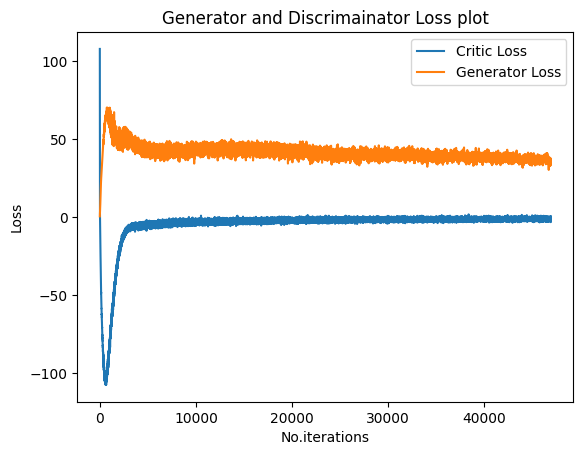

In [16]:
plot_loss(Loss_Disc,Loss_Gen)